In [7]:
import pandas as pd
import numpy as np

from CTGAN_master.ctgan import *

from urllib.request import Request, urlopen
from urllib.parse import urlencode, quote_plus
from pandas.io.json import json_normalize
import json

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score
from fairlearn.metrics import (
    MetricFrame,
    true_positive_rate,
    true_negative_rate,
    false_positive_rate,
    false_negative_rate,
    selection_rate,
    count,
)

In [26]:
def verification(before_data, after_data, test_data, target, subgroup, model_name):
    
    cols = list(before_data.columns)
    except_target = cols.copy()
    except_target.remove(target)
    
    before_matrix_a, before_matrix_b, before_info_a, before_info_b = get_info(before_data, test_data, target, subgroup, except_target, model_name)
    after_matrix_a, after_matrix_b, after_info_a, after_info_b = get_info(after_data, test_data, target, subgroup, except_target, model_name)
    
    score_TPR = (abs(before_info_a[0]-before_info_b[0])-abs(after_info_a[0]-after_info_b[0]))/abs(before_info_a[0]-before_info_b[0])
    # print("Equality of Opportunity : " + str(score_TPR*100) + " %")

    score_TPRFPR = ((abs(before_info_a[0]-before_info_b[0])-abs(after_info_a[0]-after_info_b[0]))/abs(before_info_a[0]-before_info_b[0]) + 
                    (abs(before_info_a[1]-before_info_b[1])-abs(after_info_a[1]-after_info_b[1]))/abs(before_info_a[1]-before_info_b[1]))/2
    # print("Equalized odds : " + str(score_TPRFPR*100) + " %")

    score_ED = (abs(before_info_a[3]-before_info_b[3])-abs(after_info_a[3]-after_info_b[3]))/abs(before_info_a[3]-before_info_b[3])
    # print("Demographic Parity : " + str(score_DP*100) + " %")

    score_TE = (abs(before_info_a[4]-before_info_b[4])-abs(after_info_a[4]-after_info_b[4]))/abs(before_info_a[4]-before_info_b[4])
    # print("Treatment Equal : " + str(score_TR*100) + " %")
    
    score = [score_TPR, score_TPRFPR, score_ED, score_TE]
    

#     avg_score = (score_TPR+score_TPRFPR+score_ED+score_TE)/4
#     print(
#           " Avg : "+str(avg_score*100)[:5] + " %" 
#         + " Equal Opportunity : "+str(score_TPR*100)[:5] + " %" 
#         + " Equalized Odd : "+str(score_TPRFPR*100)[:5] + " %" 
#         + " Equalizing Disincentives : "+str(score_ED*100)[:5] + " %" 
#         + " Treatment Equal : "+str(score_TE*100)[:5] + " %"
#          )
#     print("--------------------------------------------------------")
    
#     before_result = [before_matrix_a, before_matrix_b, before_info_a, before_info_b]
#     after_result = [after_matrix_a, after_matrix_b, after_info_a, after_info_a]
    
#     return before_result, after_result, score

    return np.array(score)



def get_matrix(y_test, y_hat) : 
    tp = np.sum((y_test ==1) & (y_hat==1) )
    tn = np.sum((y_test ==0) & (y_hat==0) )
    fp = np.sum((y_test ==0) & (y_hat==1) )
    fn = np.sum((y_test ==1) & (y_hat==0) )
    
    return tp, tn, fp, fn

def get_info(train_data, test_data, target, subgroup, except_target, model_name) : 
    y_train=train_data[target].astype(int)
    X_train=train_data[except_target].astype(int)

    CATEGORY  =  subgroup
    SUBGROUP = 0 
    X_test_a  = test_data.loc[test_data[CATEGORY] == SUBGROUP][except_target]
    y_test_a  = test_data.loc[test_data[CATEGORY] == SUBGROUP][target]

    SUBGROUP = 1 
    X_test_b  = test_data.loc[test_data[CATEGORY] == SUBGROUP][except_target]
    y_test_b  = test_data.loc[test_data[CATEGORY] == SUBGROUP][target]

    model = return_model(model_name)
    model.fit(X_train, y_train)

    y_hat = model.predict(X_test_a)
    before_tp_a, before_tn_a, before_fp_a, before_fn_a = get_matrix(y_test_a, y_hat)

    before_tpr_a = before_tp_a/(before_tp_a+before_fn_a)
    before_fpr_a = before_fp_a/(before_fp_a+before_tn_a)
    before_fnr_a = before_fn_a/(before_tp_a+before_fn_a)

    before_ed_a = ((before_tp_a)/(before_fn_a+before_tp_a))-((before_fp_a)/(before_fp_a+before_tn_a))
    before_te_a = before_fpr_a / before_fnr_a
    
    
    y_hat = model.predict(X_test_b)
    before_tp_b, before_tn_b, before_fp_b, before_fn_b = get_matrix(y_test_b, y_hat)

    before_tpr_b = before_tp_b/(before_tp_b+before_fn_b)
    before_fpr_b = before_fp_b/(before_fp_b+before_tn_b)
    before_fnr_b = before_fn_b/(before_tp_b+before_fn_b)

    before_ed_b = ((before_tp_b)/(before_fn_b+before_tp_b))-((before_fp_b)/(before_fp_b+before_tn_b))
    before_te_b = before_fpr_b / before_fnr_b
    
    
    matrix_a = [ before_tp_a, before_tn_a, before_fp_a, before_fn_a ]
    matrix_b = [ before_tp_b, before_tn_b, before_fp_b, before_fn_b ]
    
    info_a = [before_tpr_a, before_fpr_a, before_fnr_a, before_ed_a, before_te_a]
    info_b = [before_tpr_b, before_fpr_b, before_fnr_b, before_ed_b, before_te_b]
    
    return matrix_a, matrix_b, info_a, info_b
    
    
def return_model(model_name) : 
    if model_name == 'GaussianNB' : 
        model = GaussianNB()

    elif model_name == 'LogisticRegression' : 
        model = LogisticRegression()

    elif model_name == 'SGDClassifier' : 
        model = SGDClassifier()

    elif model_name == 'SVC' : 
        model = SVC()

    elif model_name == 'KNeighborsClassifier' : 
        model = KNeighborsClassifier()

    elif model_name == 'RandomForestClassifier' : 
        model = RandomForestClassifier()

    elif model_name == 'DecisionTreeClassifier' : 
        model = DecisionTreeClassifier()

    else : 
        print('No Matching Model -> GaussianNB')
        model = GaussianNB()
    return model

In [9]:
def make_uniq_list(data, uniq_list, group_list, target, subgroup):
    
    tg_list = []
    for tg in [0,1]:
        sg_list = []
        for sg in [0,1]:
            df_list = dict()
            for tr in uniq_list:
                tmp = data[(data[target] == tg) & (data[subgroup] == sg)].copy()
                for col, uniq in zip(group_list, tr):
                    tmp = tmp[tmp[col] == uniq].copy()
                df_list[tr] = tmp
            sg_list.append(df_list)
        tg_list.append(sg_list)
    return tg_list

In [10]:
url = 'http://cancerpreventionsnu.kr:3317/api/v1/heart/'
key = '7F531E98-018F-4B82-80D4-ACE525B1AE11'


queryParams = '?' + urlencode({quote_plus('key') : key})

response = urlopen(url + queryParams)
json_api = response.read().decode("utf-8")

json_file = json.loads(json_api)

before_data = pd.DataFrame(json_file['data'][1:], columns = json_file['data'][0])

for i in before_data.columns : 
    before_data[i] = before_data[i].astype('int')


label = 'heart_risk10'
subgroup = 'sex'

cols = before_data.columns
features = list(cols)
features.remove(label)

le_dict = {}
for i in before_data.columns :
    before_data[i] = before_data[i].astype('str')
    
    le = LabelEncoder()
    le.fit(before_data[i])
    
    before_data[i] = le.transform(before_data[i])
    
    le_dict[i]=le

In [11]:
# %cd /gdrive/MyDrive/Fair-GAN
# before_data = pd.read_csv("compas.csv")

# before_data = before_data[['sex', 'age_cat', 'race',
#                      'juv_fel_count', 'juv_misd_count', 'juv_other_count',
#                      'priors_count', 'c_charge_degree', 'c_charge_desc',
#                      'two_year_recid']]

# before_data.fillna(0, inplace=True)

# label = 'two_year_recid'
# subgroup = 'sex'
# cols = before_data.columns
# features = list(cols)
# features.remove(label)
# model_name = len(features)


# le_dict = {}
# for i in before_data.columns :
#     before_data[i] = before_data[i].astype('str')
    
#     le = LabelEncoder()
#     le.fit(before_data[i])
    
#     before_data[i] = le.transform(before_data[i])
    
#     le_dict[i]=le

In [12]:
num = len(features)

batch = 0
while num : 
    
    chi2_new = SelectKBest(chi2, k=num).fit(before_data[features], before_data[label])
    chi2_col = chi2_new.get_support()

    f_classif_new = SelectKBest(f_classif, k=num).fit(before_data[features], before_data[label])
    f_classif_col = f_classif_new.get_support()

    mutual_info_classif_new = SelectKBest(mutual_info_classif, k=num).fit(before_data[features], before_data[label])
    mutual_info_classif_col = mutual_info_classif_new.get_support()

    #selected_features = list(cols[:-1][mutual_info_classif_col])

    selected_features = list(np.array(features)[mutual_info_classif_col])


    des00 = before_data[(before_data[label]==0) & (before_data[subgroup]==0)].groupby(list(selected_features)).count().describe()[label][2]
    des01 = before_data[(before_data[label]==0) & (before_data[subgroup]==1)].groupby(list(selected_features)).count().describe()[label][2]
    des10 = before_data[(before_data[label]==1) & (before_data[subgroup]==0)].groupby(list(selected_features)).count().describe()[label][2]
    des11 = before_data[(before_data[label]==1) & (before_data[subgroup]==1)].groupby(list(selected_features)).count().describe()[label][2]

    batch = int(min(des00, des01, des10, des11))
    
    if batch > 1: 
        break
    else : 
        num-=1
        
print(batch)
print(selected_features)

group_list = np.array(selected_features)

uniq_list = before_data[selected_features].groupby(list(group_list)).count()
uniq_list = dict(zip(uniq_list.index.values, uniq_list.values))

result_list = make_uniq_list(before_data, uniq_list, group_list,label, subgroup)

test_data = pd.DataFrame()
test_size = 0.3

for i in before_data[label].unique():
    for j in before_data[subgroup].unique():
        for k in uniq_list : 
            tmp = result_list[i][j][k].copy()
            if len(tmp) > batch : 
                tmp = tmp.sample(frac=test_size)
                test_data = pd.concat([test_data, tmp])
                result_list[i][j][k] = result_list[i][j][k].drop(tmp.index)
                
            elif len(tmp) > 1 : 
                tmp = tmp.sample(1)
                test_data = pd.concat([test_data, tmp])
                result_list[i][j][k] = result_list[i][j][k].drop(tmp.index)
                
before_data.drop(test_data.index, inplace=True)

before_data.reset_index(inplace=True, drop=True)
test_data.reset_index(inplace=True, drop=True)
print(len(before_data), len(test_data))

61
['age', 'sex', 'htn', 'fhtnyn', 'packyear', 'sd_idr2']
75773 25727


In [13]:
# test_data = before_data.sample(frac=0.3)
# before_data.drop(test_data.index, inplace=True)

# before_data.reset_index(inplace=True, drop=True)
# test_data.reset_index(inplace=True, drop=True)

In [14]:
label_reverse = before_data.copy()
label_reverse[label]= label_reverse[label].apply(lambda x:1 if x==0 else 0)

subgroup_reverse = before_data.copy()
subgroup_reverse[subgroup]= subgroup_reverse[subgroup].apply(lambda x:1 if x==0 else 0)

label_subgroup_reverse = label_reverse.copy()
label_subgroup_reverse[subgroup]= label_subgroup_reverse[subgroup].apply(lambda x:1 if x==0 else 0)

In [15]:
epoch = 100

Before Len : 75773 After Len : 100778


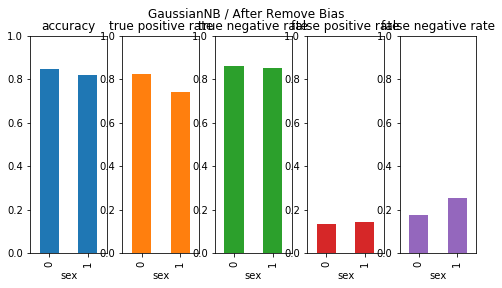

In [19]:
rgan_train = pd.concat([before_data, label_reverse, subgroup_reverse, label_subgroup_reverse])
rgan_train.reset_index(inplace=True, drop=True)

rgan = CTGANSynthesizer(epochs=epoch)
rgan.fit(before_data, rgan_train, len(before_data.columns))

after_data = rgan.sample(int(len(before_data)*0.33))

after_data = pd.concat([after_data, before_data])
after_data.reset_index(inplace=True, drop=True)

model_name = 'GaussianNB'
print_matrix(before_data, after_data, test_data, label, subgroup, model_name)

In [25]:
a = verification(before_data, after_data, test_data, label, subgroup, model_name)
b = verification(before_data, after_data, test_data, label, subgroup, model_name)
(np.array(a)+np.array(b))/2

array([0.59645729, 0.75253461, 0.22670217, 0.84650718])

In [ ]:
rgan_train = pd.concat([label_reverse, subgroup_reverse, label_subgroup_reverse])
rgan_train.reset_index(inplace=True, drop=True)

rgan = CTGANSynthesizer(epochs=epoch)
rgan.fit(before_data, rgan_train, len(before_data.columns))

after_data = rgan.sample(int(len(before_data)*0.33))

after_data = pd.concat([after_data, before_data])
after_data.reset_index(inplace=True, drop=True)

model_name = 'GaussianNB'
print_matrix(before_data, after_data, test_data, label, subgroup, model_name)

In [ ]:
rgan_train = pd.concat([label_reverse, subgroup_reverse, label_subgroup_reverse])
rgan_train.reset_index(inplace=True, drop=True)

rgan = CTGANSynthesizer(epochs=epoch)
rgan.fit(before_data, rgan_train, len(before_data.columns))
rgan_data = rgan.sample(int(len(before_data)))

gan_data = pd.concat([rgan_data,before_data])
gan = CTGANSynthesizer(epochs=epoch)
gan.fit(before_data, gan_data, len(before_data.columns))

after_data = gan.sample(int(len(before_data)*0.33))

after_data = pd.concat([after_data, before_data])
after_data.reset_index(inplace=True, drop=True)

model_name = 'GaussianNB'
print_matrix(before_data, after_data, test_data, label, subgroup, model_name)

In [ ]:
ctgan = CTGANSynthesizer(epochs=epoch)
ctgan.fit(before_data, before_data, len(before_data.columns))

after_data = ctgan.sample(int(len(before_data)*0.33))

after_data = pd.concat([after_data, before_data])
after_data.reset_index(inplace=True, drop=True)

model_name = 'GaussianNB'
print_matrix(before_data, after_data, test_data, label, subgroup, model_name)